<a href="https://colab.research.google.com/github/viveikjha/colab-notebooks/blob/master/Reduction_trt_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reduction notebook for Thai Robotic Telescope (TRT) data.
Telescopes in use currently:
1. SRO, USA
2. SBO, Australia
3. GMGO China


This notebook is for the reduction and analysis of data obtained from above telescopes. Packages used are mentioned below.

This notebook should work with Python versions 3.7+

#Obtain the data from my GitHub page.
(Around 5GB download in total, will take around 4-5 minutes for complete download)

In [ ]:
!git clone https://github.com/viveikjha/trt-data

Cloning into 'trt-data'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 667 (delta 1), reused 244 (delta 1), pack-reused 423
Receiving objects: 100% (667/667), 4.25 GiB | 28.88 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (657/657), done.


Necessary python packages to be installed for this analysis. We should install all packages here only to save time and make it more clear.

In [ ]:
!pip install astroalign
!pip install ginga
!pip install ccdproc
!pip install photutils


In [ ]:
import numpy as np
import matplotlib as mp
import ccdproc,os,sys,time,random
from glob import glob
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.time import Time
from astropy.wcs import WCS
import astroalign as aa
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.visualization import ImageNormalize, LogStretch
from matplotlib.ticker import LogLocator
from astropy.stats import SigmaClip, mad_std
from photutils.background import Background2D, MeanBackground,SExtractorBackground
from photutils import find_peaks, CircularAperture, CircularAnnulus, aperture_photometry
from photutils.centroids import centroid_2dg
from astropy.stats import SigmaClip, mad_std
from photutils import Background2D, MedianBackground, DAOStarFinder
from photutils.utils import calc_total_error
from photutils.detection import findstars

Just checking the data completeness etc..Multiple things can be done here.

In [175]:
!cd /content/trt-data/
!du -h


1.1G	.


In [179]:
!cd /content/trt-data/MRK493/
import glob
files=sorted(glob.glob("*I.wcs.fits"))
print(len(files))

24


Viewing a few images (FITS)

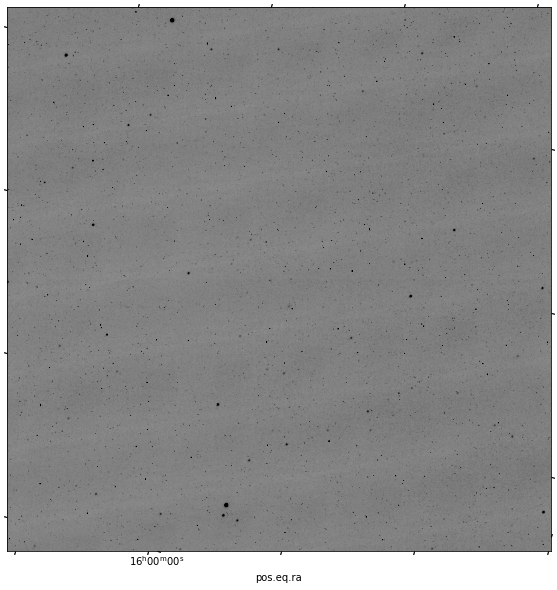

In [194]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np

for i in range(0,1):
  data=fits.open(files[i])
  image=data[0].data
  mean,std=np.mean(image),np.std(image)
  wcs=WCS(data[0].header)
  plt.figure(figsize=(10,10))
  ax=plt.subplot(projection=wcs)
  ax.imshow(image,cmap='gray_r',vmin=mean-5*std,vmax=mean+5*std)
  plt.show()


GINGA integration can also be done if required.

In [183]:

from ginga.web.pgw import ipg
use_opencv = False

server = ipg.make_server(host='0.0.0.0', port=9995, use_opencv=use_opencv)
server.start(no_ioloop=True)

Importing the necessary modules..all at once. 

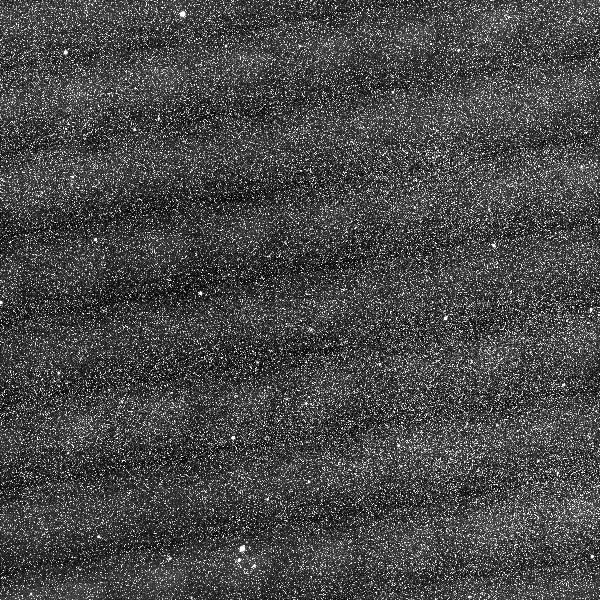

In [184]:
v1 = server.get_viewer('v1')
v1.load(files[0])
v1.embed(height=650)
v1.show()


# 1. Cleaning the images

This module is meant for cleaning the images. The tasks to be included are: bias correction, flat correction, trimming, overscan as well as the cosmic ray removal from the science cases. (For the time we are skipping the overscan and trimming part.)




Step 1: Bias correction 

Note: this step assumes multiple bias files to generate the mbias. If mbias exists already, skip this block.


In [ ]:
gain = 2 * u.electron / u.adu  # gain and readout noise are properties of the CCD and will change for different CCDs.
readnoise = 7.5 * u.electron

#ra=input('Enter the RA of the source:   ')
#dec=input('Enter the DEC of the source: ')


bias_files = sorted(glob(os.path.join(path,'bias*.fits')))
biaslist = []
for i in range (0,len(bias_files)):
    data= ccdproc.CCDData.read(bias_files[i],unit='adu')
        #data = ccdproc.create_deviation(data, gain=gain, readnoise=readnoise)
        #data= data-(data.uncertainty.array)
    biaslist.append(data)
    
masterbias = ccdproc.combine(biaslist,method='average',sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)
masterbias.write('masterbias.fits', overwrite=True)
mbias=ccdproc.CCDData.read('masterbias.fits',unit='adu')
print('Master bias generated')
print(" Mean and median of the masterbias: ",np.mean(masterbias), np.median(masterbias))




Step 2:Flat correction

Note: This step assumes multiple flat files for different bands to generate mflat.fits. If mflat exists, skip this block.

In [ ]:
flat_files=sorted(glob(os.path.join(dir,'flat*.fits')))
flatlist = []
for j in range(0,len(flat_files)):
    flat=ccdproc.CCDData.read(flat_files[j],unit='adu')
    flat_bias_removed=ccdproc.subtract_bias(flat,masterbias)
    flatlist.append(flat_bias_removed)

    def inv_median(a):
        return 1 / np.median(a)

masterflat = ccdproc.combine(flatlist,method='median', scale=inv_median,
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std)
masterflat.write('masterflat.fits', overwrite=True)
mflat=ccdproc.CCDData.read('masterflat.fits',unit='adu')
print('Master flat generated')
print(" Mean and median of the masterflat: ",np.mean(masterflat), np.median(masterflat))



Step 3: Final bias, flat correction and cosmic ray removal.

In [ ]:
filename="*I.wcs.fits"
file_names = sorted(glob.glob(filename))
for i in range(0,len(file_names)):
    print(file_names[i])
    image=ccdproc.CCDData.read(file_names[i],unit='adu')
    header=fits.getheader(file_names[i],0)
    #mbias=ccdproc.CCDData.read('masterbias.fits',unit='adu')
    #mflat=ccdproc.CCDData.read('masterflat.fits',unit='adu')
    #bias_subtracted = ccdproc.subtract_bias(image, mbias)
    #flat_corrected = ccdproc.flat_correct(bias_subtracted, mflat)
    #cr_cleaned = ccdproc.cosmicray_lacosmic(flat_corrected,readnoise=7.5, sigclip=5,satlevel=65535,niter=20,cleantype='meanmask',gain_apply=True)
        #print('Cosmic rays removed')
    #clean_file=file_names[i].replace('.fits','')
    #fits.writeto(clean_file+'_cleaned.fits',cr_cleaned,header,overwrite=True)
    print('Image no-%i has been cleaned'%i)

# 2. Aligning the images

Aligning the science frames using astroalign for all the bands.

In [ ]:
image_path='/content/trt-data/MRK493/'
filename='*I.wcs.fits'
files=sorted(glob.glob(os.path.join(image_path,filename)))
print(len(files))

ref_image=fits.open(files[2])
reference_image=ref_image[0].data

for i in range(0,1):
    image_data=fits.open(files[i])
    source_image=image_data[0].data
    header=image_data[0].header
    image_aligned,footprint=aa.register(source_image,reference_image)

    aligned_file=files[i].replace('.fits','')
    fits.writeto(aligned_file+'_aligned'+'.fits',image_aligned,header,overwrite=True)
    #os.system("mv *aligned* aligned/")
    print('No. %i alignment done'%i)




In [ ]:
    data,header=fits.getdata(files[2],header=True)
    #exposure=header['EXPOSURE']
    exposure=300
    print('Exposure is',exposure)

    sigma_clip = SigmaClip(sigma=3, maxiters=10)
    bkg_estimator = SExtractorBackground()
    bkg = Background2D(data, (10,10), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    back=bkg.background # this is the background we need for the background subtraction.
    back2=np.median(bkg.background)
    print('median background is',back2)

    mask = data == 0
    unit = u.electron / u.s


    xdf_image = CCDData(data, unit=unit, meta=header, mask=mask)
    norm_image = ImageNormalize(vmin=1e-4, vmax=5e-2, stretch=LogStretch(), clip=False)
    xdf_image_clipped = np.clip(xdf_image, 1e-4, None)

    mean, median, std = sigma_clipped_stats(xdf_image.data, sigma=3.0, maxiters=20, mask=xdf_image.mask)

Exposure is 300
median background is 3403.2155189510713


In [ ]:
print('Finding the sources')
daofind = DAOStarFinder(fwhm=5, threshold=20*std) # 3 sigma above the background.
sources = daofind(data-back)

Finding the sources


In [ ]:
from astropy import units as u
from astropy.coordinates import SkyCoord
print('We have found:',len(sources),' sources')
px,py=sources['xcentroid'], sources['ycentroid']
wx, wy = wcs.wcs_pix2world(px,py, 1)
c=SkyCoord(ra=wx*u.degree,dec=wy*u.degree)
print(c.to_string('hmsdms')[0])

We have found: 28  sources
15h59m43.8907s +34d53m07.5675s


In [ ]:
    fwhm=5
    radii=[4,6,8,10,12]

    #positions=(sources['xcentroid'], sources['ycentroid'])
    apertures = [CircularAperture(positions, r=r) for r in radii]

    an_ap = CircularAnnulus(positions, r_in=14, r_out=14.5)
    #apers = [apertures, annulus_apertures]

    

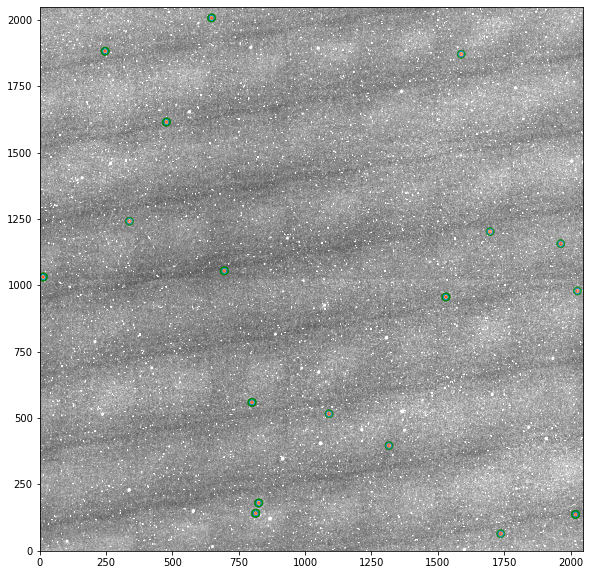

In [ ]:
    plt.figure(figsize=(10,10))
    plt.imshow(data,cmap='gray',origin='lower',vmin=mean-4*std,vmax=mean+4*std)
    colors=['red','salmon','yellow','blue','cyan']
    for i in range(len(apertures)):
        apertures[i].plot(color=colors[i], alpha=0.7)

    an_ap.plot(color='green', alpha=0.7)
    plt.show()

In [ ]:
    #bkg_sigma=mad_std(data)
    effective_gain=exposure
    error=calc_total_error(data,back,effective_gain)


    #error=0.1*data
    phot_table = aperture_photometry(data-back, apertures,error=error)
    phot_table2=aperture_photometry(data-back,an_ap)


    bkg_mean = phot_table2['aperture_sum'] / an_ap.area
    bkg_sum = bkg_mean * an_ap.area


    final_sum0=phot_table['aperture_sum_0']-bkg_sum
    final_sum1=phot_table['aperture_sum_1']-bkg_sum
    final_sum2=phot_table['aperture_sum_2']-bkg_sum
    final_sum3=phot_table['aperture_sum_3']-bkg_sum
    final_sum4=phot_table['aperture_sum_4']-bkg_sum

Now, we have the total flux for different apertures. To convert these flux to magnitudes we ca use:



```
apparent_magnitude = -2.5log(final_sum) + zp
```


where zp is the photometric zero point for a given aperture, calculated from apparent magnitudes of the known sources.

We need to figure out how manu known sources are available in the field, and then get their magnitudes.

In [ ]:
    #zp=25 for the time being
    mag_back=-2.5*np.log10(bkg_mean/exposure)
    mag_0=-2.5*np.log10(final_sum0/exposure)
    mag_1=-2.5*np.log10(final_sum1/exposure)
    mag_2=-2.5*np.log10(final_sum2/exposure)
    mag_3=-2.5*np.log10(final_sum3/exposure)
    mag_4=-2.5*np.log10(final_sum4/exposure)

    flux_err_0=phot_table['aperture_sum_err_0']
    mag_err_0=1.09*flux_err_0/final_sum0

    flux_err_1=phot_table['aperture_sum_err_1']
    mag_err_1=1.09*flux_err_1/final_sum1

    flux_err_2=phot_table['aperture_sum_err_2']
    mag_err_2=1.09*flux_err_2/final_sum2

    flux_err_3=phot_table['aperture_sum_err_3']
    mag_err_3=1.09*flux_err_3/final_sum3

    flux_err_4=phot_table['aperture_sum_err_4']
    mag_err_4=1.09*flux_err_4/final_sum4



    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


The curve of growth which provides an optimum aperture in which we have to extract our photometric fluxes will be done next.

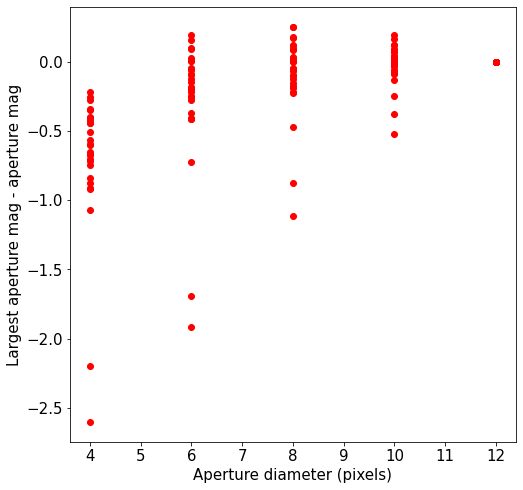

In [ ]:
x=radii
plt.figure(figsize = (8,8))
for i in range(0,len(mag_0)):
  y=[]
  y.append(mag_4[i]-mag_0[i])
  y.append(mag_4[i]-mag_1[i])
  y.append(mag_4[i]-mag_2[i])
  y.append(mag_4[i]-mag_3[i])
  y.append(mag_4[i]-mag_4[i])  
  plt.plot(x,y, 'ro')
  plt.xlabel('Aperture diameter (pixels)', fontsize=15)
  plt.ylabel('Largest aperture mag - aperture mag', fontsize = 15)
  plt.xticks(fontsize = 15)
  plt.yticks(fontsize = 15)
plt.show()

Finally, writing the magnitudes and corrsponding Julian dates to the text file for light curve purposes.

25.12500588923624 17.461246418630196 17.282427421317344 17.024432171116786 16.709438837932368 16.352676651624954


Remaining time on colab.. 

(very important)

In [197]:
import time, psutil
uptime = time.time() - psutil.boot_time()
remain = 12*60*60 - uptime
print(remain/(60))

111.38769053618113
